In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings("ignore", message="Mean of empty slice")
warnings.filterwarnings("ignore", message="Degrees of freedom <= 0 for slice")


df = pd.read_parquet("df_cleaned_resit.parquet")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(["pump_id", "timestamp"])



In [14]:
#define failure horizon

failure_dates = {
    "A": [
        pd.Timestamp("2025-03-11 23:59:59"),
        pd.Timestamp("2025-09-04 23:59:59")
    ],
    "B": [
        pd.Timestamp("2024-12-05 23:59:59"),
        pd.Timestamp("2025-05-02 23:59:59")
    ]
}

H = pd.Timedelta("7 days")
df["label"] = 0




In [15]:
#assign lables at time-series level

for pump, dates in failure_dates.items():
    df_p = df[df["pump_id"] == pump]

    for d in dates:
        last_valid = df_p[df_p["timestamp"] <= d]["timestamp"].max()
        if pd.isna(last_valid):
            continue

        start = last_valid - H

        mask = (
            (df["pump_id"] == pump) &
            (df["timestamp"] > start) &
            (df["timestamp"] <= last_valid)
        )

        df.loc[mask, "label"] = 1


In [16]:
df.groupby("pump_id")["label"].value_counts()


pump_id  label
A        0        51719
         1         2016
B        0        51719
         1         2016
Name: count, dtype: int64

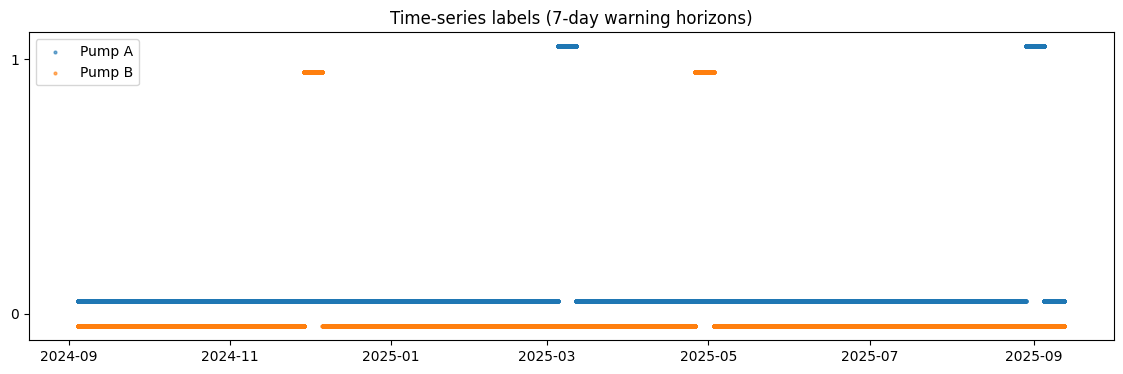

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 4))

for pump in ["A", "B"]:
    sub = df[df["pump_id"] == pump]
    ax.scatter(
        sub["timestamp"],
        sub["label"] + (0.05 if pump == "A" else -0.05),
        s=4,
        label=f"Pump {pump}",
        alpha=0.6
    )

ax.set_yticks([0, 1])
ax.set_title("Time-series labels (7-day warning horizons)")
ax.legend()
plt.show()


In [18]:
#feature extraction 

def build_windows(df, W_days=21, stride_hours=1):

    W = pd.Timedelta(days=W_days)
    windows = []

    for pump in df["pump_id"].unique():

        df_p = df[df["pump_id"] == pump].set_index("timestamp").sort_index()

        end_times = (
            df_p.index
            .to_series()
            .dt.floor("h")
            .drop_duplicates()
        )

        for end_time in end_times:
            start_time = end_time - W
            w = df_p.loc[(df_p.index > start_time) & (df_p.index <= end_time)]

            if len(w) == 0:
                continue

            label = df_p.loc[:end_time]["label"].iloc[-1]

            windows.append({
                "pump_id": pump,
                "end_time": end_time,
                "label": int(label),
                "window_df": w
            })

    return windows


windows_21 = build_windows(df)


In [20]:
#check

pd.DataFrame(windows_21).groupby(["pump_id", "label"]).size()


pump_id  label
A        0        8620
         1         336
B        0        8620
         1         336
dtype: int64

In [21]:
durations = [
    (w["window_df"].index.max() - w["window_df"].index.min())
    for w in windows_21
]

pd.Series(durations).describe()


count                         17912
mean     20 days 09:39:40.973648950
std       2 days 19:31:29.511570714
min                 0 days 00:30:00
25%                20 days 23:50:00
50%                20 days 23:50:00
75%                20 days 23:50:00
max                20 days 23:50:00
dtype: object

In [23]:
w = windows_21[500]  # any index

print("Pump:", w["pump_id"])
print("Label:", w["label"])
print("Start:", w["window_df"].index.min())
print("End:", w["window_df"].index.max())
print("Rows:", len(w["window_df"]))

w["window_df"].head()


Pump: A
Label: 0
Start: 2024-09-04 11:30:00
End: 2024-09-25 08:00:00
Rows: 3004


,suction,discharge,output,flow_primary,flow_total,tank_level,drymatter_1,drymatter_2,drymatter_3,productcode_1,productcode_2,productcode_3,pump_id,label
timestamp,,,,,,,,,,,,,,
2024-09-04 11:30:00,1.499592,3.617833,15.410932,1.647647,3.123060,2.445410,58.902445,60.530755,58.770573,0.0,1.0,0.0,A,0
2024-09-04 11:40:00,1.532229,3.142893,12.059634,1.082256,2.446991,2.468781,58.917043,60.521769,58.791695,0.0,1.0,0.0,A,0
2024-09-04 11:50:00,1.533503,2.884417,10.512563,0.848890,2.144818,2.471946,58.922533,60.554102,58.790404,0.0,1.0,0.0,A,0
2024-09-04 12:00:00,1.500483,3.324420,13.812538,0.947077,2.805400,2.466533,58.919761,60.613662,58.789230,0.0,1.0,0.0,A,0
2024-09-04 12:10:00,1.492766,3.193281,13.196538,0.748807,2.675767,2.446744,58.919086,60.594212,58.787864,0.0,1.0,0.0,A,0


In [24]:
def slope(series):
    s = series.dropna().values
    if len(s) < 2:
        return np.nan
    x = np.arange(len(s))
    m, _ = np.polyfit(x, s, 1)
    return m


def extract_features_from_window(w):
    df_w = w["window_df"].copy()

    # Differential pressure
    df_w["delta_p"] = df_w["discharge"] - df_w["suction"]
    df_w["active_pressure"] = (
        (df_w["delta_p"] >= 7.0) & (df_w["delta_p"] <= 8.4)
    ).astype(int)

    features = {
        "pump_id": w["pump_id"],
        "end_time": w["end_time"],
        "label": w["label"],

        # ΔP
        "delta_p_mean": df_w["delta_p"].mean(),
        "delta_p_std": df_w["delta_p"].std(),
        "delta_p_trend": slope(df_w["delta_p"]),
        "active_pressure_fraction": df_w["active_pressure"].mean(),

        # Output
        "output_mean": df_w["output"].mean(),
        "output_std": df_w["output"].std(),
        "output_trend": slope(df_w["output"]),

        # Pressures
        "suction_mean": df_w["suction"].mean(),
        "suction_std": df_w["suction"].std(),
        "discharge_mean": df_w["discharge"].mean(),
        "discharge_std": df_w["discharge"].std(),

        # Flow
        "flow_primary_mean": df_w["flow_primary"].mean(),
        "flow_total_mean": df_w["flow_total"].mean(),

        # Tank
        "tank_level_mean": df_w["tank_level"].mean(),
        "tank_level_std": df_w["tank_level"].std(),

        # Dry matter
        "dm1_mean": df_w["drymatter_1"].mean(),
        "dm1_std": df_w["drymatter_1"].std(),
        "dm2_mean": df_w["drymatter_2"].mean(),
        "dm2_std": df_w["drymatter_2"].std(),
        "dm3_mean": df_w["drymatter_3"].mean(),
        "dm3_std": df_w["drymatter_3"].std(),

        # Product codes (fractions)
        "pc1_fraction": df_w["productcode_1"].mean(),
        "pc2_fraction": df_w["productcode_2"].mean(),
        "pc3_fraction": df_w["productcode_3"].mean(),
    }

    return features


In [26]:
#build features and drop nan windows

df_features = pd.DataFrame(
    extract_features_from_window(w) for w in windows_21
)

df_features_clean = df_features.dropna().reset_index(drop=True)

print("Total windows:", len(df_features))
print("Valid windows:", len(df_features_clean))
print("Dropped windows:", len(df_features) - len(df_features_clean))




Total windows: 17912
Valid windows: 17741
Dropped windows: 171


In [29]:
df_features.groupby("label").size()
df_features_clean.groupby("label").size()


label
0    17069
1      672
dtype: int64

In [30]:
df_features.groupby("pump_id").size()
df_features_clean.groupby("pump_id").size()


pump_id
A    8785
B    8956
dtype: int64

In [33]:
dropped_idx = df_features.index.difference(df_features_clean.index)
example_idx = dropped_idx[141]

df_features.loc[example_idx]


pump_id                                       B
end_time                    2025-09-11 10:00:00
label                                         0
delta_p_mean                           3.171275
delta_p_std                            3.239807
delta_p_trend                          0.000446
active_pressure_fraction               0.214616
output_mean                           30.194908
output_std                            20.402299
output_trend                           0.002253
suction_mean                             1.6949
suction_std                            0.488128
discharge_mean                         4.866175
discharge_std                          3.152271
flow_primary_mean                      1.914866
flow_total_mean                        5.837793
tank_level_mean                        2.214818
tank_level_std                         0.712567
dm1_mean                              48.272263
dm1_std                               21.250774
dm2_mean                               4

In [34]:
# Define pump lifecycles (end exclusive)
cycles = {
    "A": [
        ("A1", pd.Timestamp("2024-09-04"), pd.Timestamp("2025-03-12")),
        ("A2", pd.Timestamp("2025-03-12"), pd.Timestamp("2025-09-05")),
    ],
    "B": [
        ("B1", pd.Timestamp("2024-09-18"), pd.Timestamp("2024-12-06")),
        ("B2", pd.Timestamp("2024-12-06"), pd.Timestamp("2025-05-03")),
        ("B3", pd.Timestamp("2025-05-03"), pd.Timestamp("2025-09-05")),
    ]
}



In [35]:
df_features_clean["cycle_id"] = None

for idx, row in df_features_clean.iterrows():
    pump = row["pump_id"]
    t = row["end_time"]

    for cid, start, end in cycles[pump]:
        if start <= t < end:
            df_features_clean.at[idx, "cycle_id"] = cid
            break


In [36]:
df_features_clean["cycle_id"].value_counts()


cycle_id
A1    4524
A2    4077
B2    3552
B3    3000
B1    1896
Name: count, dtype: int64

In [45]:
# B2 must contain positives
df_features_clean[df_features_clean["cycle_id"] == "A2"]["label"].value_counts()


label
0    3909
1     168
Name: count, dtype: int64

In [46]:
df_features_clean.to_parquet(
    "df_preprocessed_windows.parquet",
    index=False
)
